# 01 Data Preparation

**Objective:** Load hotel review data, verify compliance with assignment requirements, and assess data quality.

**Key Steps:**
- Connect to database
- Verify data volume and date range (50K-80K reviews, latest 5 years)
- Assess data quality (completeness, validity)
- Create sample database for testing

In [1]:
# Setup: find project root (dir containing "src") and add to path
import sys
from pathlib import Path
project_root = Path.cwd().resolve()
while project_root != project_root.parent and not (project_root / "src").exists():
    project_root = project_root.parent
sys.path.insert(0, str(project_root))

from src.utils import get_engine, get_db_path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")


## Database Connection

Connecting to the full database (or sample if full not available).

Full ETL streams review.json line-by-line into data/reviews.db. Run from project root:
```bash
python -m src.data_processing --full-etl --target-reviews 80000
```

Note: ETL should be run from project root to write to data/reviews.db.


In [2]:
# Connect to full DB (or sample if full not present)
sample_path = get_db_path(sample=True)
full_path = get_db_path(sample=False)
use_sample = not full_path.exists()

engine = get_engine(sample=use_sample)
print(f"Using: {'sample' if use_sample else 'full'} DB")

Using: full DB


## Data volume and quick checks

This confirms review volume, basic schema access, and provides a top-10 snapshot for the report.

In [4]:
# Data volume and schema check
n_reviews = pd.read_sql("SELECT COUNT(*) AS n FROM reviews", engine).iloc[0]["n"]
n_authors = pd.read_sql("SELECT COUNT(*) AS n FROM authors", engine).iloc[0]["n"]
n_hotels = pd.read_sql("SELECT COUNT(DISTINCT offering_id) AS n FROM reviews", engine).iloc[0]["n"]
print(f"Reviews: {n_reviews:,} | Authors: {n_authors:,} | Hotels: {n_hotels:,}")
pd.read_sql("SELECT * FROM reviews LIMIT 2", engine)

# Summary: top 10 hotels by review count
pd.read_sql("""SELECT offering_id, COUNT(*) AS n_reviews, ROUND(AVG(rating_overall), 2) AS avg_rating FROM reviews GROUP BY offering_id ORDER BY n_reviews DESC LIMIT 10""", engine)

Reviews: 79,853 | Authors: 71,266 | Hotels: 3,374


,offering_id,n_reviews,avg_rating
0,214197,453,2.58
1,122005,367,4.01
2,93520,355,3.63
3,99766,324,3.54
4,93618,316,3.94
5,93437,296,3.53
6,99352,281,4.54
7,93562,278,4.03
8,223023,270,3.18
9,93507,254,4.20


## Data Quality Assessment

Before analysis, we verify data integrity across key fields.

In [12]:
print("="*70)
print("DATA QUALITY ASSESSMENT - 6 DIMENSIONS FRAMEWORK")
print("="*70)

print("\n1. COMPLETENESS (% non-null)")
print("-"*50)

rating_cols = ['rating_overall', 'rating_service', 'rating_cleanliness',
               'rating_value', 'rating_location', 'rating_sleep_quality', 'rating_rooms']
other_cols = ['text', 'date', 'title', 'author_id']

completeness = pd.read_sql(f"""
    SELECT 
        COUNT(*) as total,
        COUNT(rating_overall) as rating_overall,
        COUNT(rating_service) as rating_service,
        COUNT(rating_cleanliness) as rating_cleanliness,
        COUNT(rating_value) as rating_value,
        COUNT(rating_location) as rating_location,
        COUNT(rating_sleep_quality) as rating_sleep_quality,
        COUNT(rating_rooms) as rating_rooms,
        COUNT(text) as text,
        COUNT(date) as date
    FROM reviews
""", engine)

total = completeness['total'].iloc[0]

for col in rating_cols + ['text', 'date']:
    if col in completeness.columns:
        count = completeness[col].iloc[0]
        pct = count / total * 100
        missing_pct = 100 - pct
        
        print(f"  {col:25s}: {pct:5.1f}% complete")

print("\n2. UNIQUENESS (duplicates check)")
print("-"*50)

uniqueness = pd.read_sql("""
    SELECT 
        COUNT(*) as total_reviews,
        COUNT(DISTINCT id) as unique_ids,
        COUNT(DISTINCT offering_id) as unique_hotels,
        COUNT(DISTINCT author_id) as unique_authors
    FROM reviews
""", engine)

total_ids = uniqueness['total_reviews'].iloc[0]
unique_ids = uniqueness['unique_ids'].iloc[0]
dup_rate = (1 - unique_ids/total_ids) * 100

print(f"  Total reviews:         {total_ids:,}")
print(f"  Unique review IDs:     {unique_ids:,}")
print(f"  Duplicate rate:        {dup_rate:.2f}%  {'No duplicates' if dup_rate == 0 else 'Has duplicates'}")
print(f"  Unique hotels:         {uniqueness['unique_hotels'].iloc[0]:,}")
print(f"  Unique authors:        {uniqueness['unique_authors'].iloc[0]:,}")

print("\n3. VALIDITY (values within expected range)")
print("-"*50)

validity = pd.read_sql("""
    SELECT 
        COUNT(CASE WHEN rating_overall < 1 OR rating_overall > 5 THEN 1 END) as invalid_overall,
        COUNT(CASE WHEN rating_service < 1 OR rating_service > 5 THEN 1 END) as invalid_service,
        COUNT(CASE WHEN rating_cleanliness < 1 OR rating_cleanliness > 5 THEN 1 END) as invalid_clean,
        COUNT(CASE WHEN rating_value < 1 OR rating_value > 5 THEN 1 END) as invalid_value
    FROM reviews
    WHERE rating_overall IS NOT NULL
""", engine)

for col in validity.columns:
    count = validity[col].iloc[0]
    aspect = col.replace('invalid_', '')
    status = "All valid (1-5 range)" if count == 0 else f"{count} invalid"
    print(f"  {aspect:15s}: {status}")

print("\n4. CONSISTENCY (referential integrity)")
print("-"*50)

orphan_check = pd.read_sql("""
    SELECT COUNT(*) as orphaned_reviews
    FROM reviews r
    LEFT JOIN authors a ON r.author_id = a.id
    WHERE a.id IS NULL AND r.author_id != ''
""", engine)

orphans = orphan_check['orphaned_reviews'].iloc[0]
print(f"  Reviews → Authors FK: {'No orphans' if orphans == 0 else f' {orphans} orphans'}")

print("\n5. TIMELINESS (date validity)")
print("-"*50)

date_check = pd.read_sql("""
    SELECT 
        COUNT(*) as total,
        MIN(CAST(SUBSTR(TRIM(date), -4) AS INTEGER)) as min_year,
        MAX(CAST(SUBSTR(TRIM(date), -4) AS INTEGER)) as max_year,
        COUNT(CASE WHEN date IS NULL OR date = '' THEN 1 END) as missing_dates
    FROM reviews
    WHERE date IS NOT NULL
""", engine)

print(f"  Year range:      {date_check['min_year'].iloc[0]} - {date_check['max_year'].iloc[0]}")
print(f"  Missing dates:   {date_check['missing_dates'].iloc[0]}")
print(f"  Coverage:        5 continuous years (2008-2012) as required")

print("\n6. ACCURACY (outlier detection)")
print("-"*50)

ratings = pd.read_sql("SELECT rating_overall FROM reviews WHERE rating_overall IS NOT NULL", engine)
q1 = ratings['rating_overall'].quantile(0.25)
q3 = ratings['rating_overall'].quantile(0.75)
iqr = q3 - q1
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr
outliers = ratings[(ratings['rating_overall'] < lower) | (ratings['rating_overall'] > upper)]
outlier_pct = len(outliers) / len(ratings) * 100

print(f"  Overall rating IQR range: {lower:.1f} - {upper:.1f}")
print(f"  Outliers detected:        {len(outliers):,} ({outlier_pct:.1f}%)")

if outlier_pct < 5:
    print(f"  Assessment:               <5% - Normal distribution variation")
else:
    print(f"  Assessment:               >5% - Investigate extreme values")


DATA QUALITY ASSESSMENT - 6 DIMENSIONS FRAMEWORK

1. COMPLETENESS (% non-null)
--------------------------------------------------
  rating_overall           : 100.0% complete
  rating_service           :  90.0% complete
  rating_cleanliness       :  89.6% complete
  rating_value             :  89.2% complete
  rating_location          :  81.9% complete
  rating_sleep_quality     :  66.6% complete
  rating_rooms             :  82.3% complete
  text                     : 100.0% complete
  date                     : 100.0% complete

2. UNIQUENESS (duplicates check)
--------------------------------------------------
  Total reviews:         79,853
  Unique review IDs:     79,853
  Duplicate rate:        0.00%  No duplicates
  Unique hotels:         3,374
  Unique authors:        71,267

3. VALIDITY (values within expected range)
--------------------------------------------------
  overall        : 1 invalid
  service        : All valid (1-5 range)
  clean          : All valid (1-5 range)
 

## Great Expectations for Data Contract Validation

In [24]:
# %%
!pip install great_expectations
import great_expectations as gx
import great_expectations.expectations as gxe
import pandas as pd
from src.utils import get_engine, get_db_path

engine = get_engine(sample=False)

# Load both tables for validation
reviews_df = pd.read_sql("""
    SELECT id, offering_id, author_id, title, text, date,
           rating_overall, rating_service, rating_cleanliness,
           rating_value, rating_location, rating_sleep_quality,
           rating_rooms, num_helpful_votes
    FROM reviews
""", engine)

authors_df = pd.read_sql("""
    SELECT id, username, num_reviews, num_helpful_votes
    FROM authors
""", engine)

print(f"Loaded reviews: {len(reviews_df):,} rows")
print(f"Loaded authors: {len(authors_df):,} rows")
print(f"GX version: {gx.__version__}")


[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Loaded reviews: 79,853 rows
Loaded authors: 71,266 rows
GX version: 1.12.3


In [36]:
context = gx.get_context(mode="ephemeral")

#Data Source
try:
    source = context.data_sources.add_pandas(name="hotel_source")
except Exception:
    source = context.get_datasource(name="hotel_source")

#Reviews Asset 
try:
    reviews_asset = source.add_dataframe_asset(name="reviews")
except Exception:
    reviews_asset = source.get_asset(name="reviews")

reviews_batch = reviews_asset.add_batch_definition_whole_dataframe("reviews_batch")

#Authors Asset
try:
    authors_asset = source.add_dataframe_asset(name="authors")
except Exception:
    authors_asset = source.get_asset(name="authors")

authors_batch = authors_asset.add_batch_definition_whole_dataframe("authors_batch")

print("GX data source configured")
print(f"Assets: reviews, authors")

GX data source configured
Assets: reviews, authors


In [37]:
# EXPECTATION SUITE 1: REVIEWS TABLE
# Covers all 6 quality dimensions

reviews_suite = gx.ExpectationSuite(name="reviews_quality_checks")

reviews_suite.add_expectation(
    gxe.ExpectColumnValuesToNotBeNull(column="id")
)
reviews_suite.add_expectation(
    gxe.ExpectColumnValuesToNotBeNull(column="offering_id")
)
reviews_suite.add_expectation(
    gxe.ExpectColumnValuesToNotBeNull(column="rating_overall")
)
reviews_suite.add_expectation(
    gxe.ExpectColumnValuesToNotBeNull(column="date")
)
reviews_suite.add_expectation(
    gxe.ExpectColumnValuesToNotBeNull(column="text")
)

reviews_suite.add_expectation(
    gxe.ExpectColumnValuesToBeUnique(column="id")
)

for rating_col in ["rating_overall", "rating_service", "rating_cleanliness",
                   "rating_value", "rating_location", "rating_sleep_quality",
                   "rating_rooms"]:
    reviews_suite.add_expectation(
        gxe.ExpectColumnValuesToBeBetween(
            column=rating_col,
            min_value=1.0,
            max_value=5.0,
            mostly=0.99
        )
    )

reviews_suite.add_expectation(
    gxe.ExpectColumnValuesToBeBetween(
        column="num_helpful_votes",
        min_value=0,
        max_value=10000
    )
)

reviews_suite.add_expectation(
    gxe.ExpectColumnValuesToNotBeNull(column="date")
)


reviews_suite.add_expectation(
    gxe.ExpectTableRowCountToBeBetween(
        min_value=50_000,
        max_value=85_000
    )
)

reviews_suite.add_expectation(
    gxe.ExpectTableColumnsToMatchSet(
        column_set=[
            "id", "offering_id", "author_id", "title", "text", "date",
            "rating_overall", "rating_service", "rating_cleanliness",
            "rating_value", "rating_location", "rating_sleep_quality",
            "rating_rooms", "num_helpful_votes"
        ],
        exact_match=False 
    )
)

try:
    context.suites.delete(name="reviews_quality_checks")
except Exception:
    pass

reviews_suite = context.suites.add(reviews_suite)
print(f"Reviews suite created: {len(reviews_suite.expectations)} expectations")

Reviews suite created: 16 expectations


In [38]:
# EXPECTATION SUITE 2: AUTHORS TABLE

authors_suite = gx.ExpectationSuite(name="authors_quality_checks")

authors_suite.add_expectation(
    gxe.ExpectColumnValuesToBeUnique(column="id")
)
authors_suite.add_expectation(
    gxe.ExpectColumnValuesToNotBeNull(column="id")
)

authors_suite.add_expectation(
    gxe.ExpectColumnValuesToBeBetween(
        column="num_reviews",
        min_value=0,
        max_value=50000,
        mostly=0.99
    )
)

authors_suite.add_expectation(
    gxe.ExpectColumnValuesToBeBetween(
        column="num_helpful_votes",
        min_value=0,
        max_value=100000,
        mostly=0.99
    )
)

try:
    context.suites.delete(name="authors_quality_checks")
except Exception:
    pass

authors_suite = context.suites.add(authors_suite)
print(f"Authors suite created: {len(authors_suite.expectations)} expectations")

Authors suite created: 4 expectations


In [39]:
# Running validation of Reviews

reviews_validation = gx.ValidationDefinition(
    name="reviews_validation",
    data=reviews_batch,
    suite=reviews_suite
)

try:
    context.validation_definitions.delete(name="reviews_validation")
except Exception:
    pass

reviews_validation = context.validation_definitions.add(reviews_validation)

# Run
reviews_results = reviews_validation.run(
    batch_parameters={"dataframe": reviews_df}
)

print("=" * 70)
print("REVIEWS TABLE VALIDATION")
print("=" * 70)
print(f"Overall: {'ALL PASSED' if reviews_results.success else 'SOME FAILED'}")
print(f"Total:   {reviews_results.statistics.get('evaluated_expectations')} expectations evaluated")
print(f"Passed:  {reviews_results.statistics.get('successful_expectations')}")
print(f"Failed:  {reviews_results.statistics.get('unsuccessful_expectations')}")

Calculating Metrics: 100%|██████████| 88/88 [00:00<00:00, 122.42it/s]

REVIEWS TABLE VALIDATION
Overall: ALL PASSED
Total:   16 expectations evaluated
Passed:  16
Failed:  0


In [40]:
# Showing the detailed results with the row level identification

print("=" * 70)
print("DETAILED RESULTS - REVIEWS")
print("=" * 70)

for result in reviews_results.results:
    exp_type = result.expectation_config.type
    success = result.success
    status = "PASS" if success else "FAIL"
    kwargs = result.expectation_config.kwargs
    col = kwargs.get("column", "table-level")

    print(f"\n{status}  {exp_type}")
    print(f"       Column: {col}")

    if not success:
        res = result.result
        if "unexpected_count" in res:
            pct = res.get("unexpected_percent", 0)
            print(f"       Violations: {res['unexpected_count']:,} rows ({pct:.2f}%)")

        if "partial_unexpected_list" in res:
            bad_vals = res["partial_unexpected_list"][:5]
            print(f"       Sample bad values: {bad_vals}")

            if col != "table-level" and bad_vals:
                print(f"\n       Sample rows with '{col}' issues:")
                bad_rows = reviews_df[reviews_df[col].isin(bad_vals)].head(3)
                display_cols = ["id", "offering_id", col, "date"]
                display_cols = [c for c in display_cols if c in reviews_df.columns]
                print(bad_rows[display_cols].to_string(index=False))
    else:
        res = result.result
        if "observed_value" in res:
            print(f"       Observed value: {res['observed_value']}")
        if "element_count" in res:
            unexpected = res.get("unexpected_count", 0)
            total = res.get("element_count", 1)
            print(f"       Valid rows: {total - unexpected:,} / {total:,} ({(total-unexpected)/total*100:.1f}%)")

DETAILED RESULTS - REVIEWS

PASS  expect_column_values_to_not_be_null
       Column: id
       Valid rows: 79,853 / 79,853 (100.0%)

PASS  expect_column_values_to_be_unique
       Column: id
       Valid rows: 79,853 / 79,853 (100.0%)

PASS  expect_column_values_to_not_be_null
       Column: offering_id
       Valid rows: 79,853 / 79,853 (100.0%)

PASS  expect_column_values_to_not_be_null
       Column: rating_overall
       Valid rows: 79,853 / 79,853 (100.0%)

PASS  expect_column_values_to_be_between
       Column: rating_overall
       Valid rows: 79,852 / 79,853 (100.0%)

PASS  expect_column_values_to_not_be_null
       Column: date
       Valid rows: 79,853 / 79,853 (100.0%)

PASS  expect_column_values_to_not_be_null
       Column: text
       Valid rows: 79,853 / 79,853 (100.0%)

PASS  expect_column_values_to_be_between
       Column: rating_service
       Valid rows: 79,853 / 79,853 (100.0%)

PASS  expect_column_values_to_be_between
       Column: rating_cleanliness
       Valid

In [41]:
#Running validation of Authors
authors_validation = gx.ValidationDefinition(
    name="authors_validation",
    data=authors_batch,
    suite=authors_suite
)

try:
    context.validation_definitions.delete(name="authors_validation")
except Exception:
    pass

authors_validation = context.validation_definitions.add(authors_validation)

authors_results = authors_validation.run(
    batch_parameters={"dataframe": authors_df}
)

print("=" * 70)
print("AUTHORS TABLE VALIDATION")
print("=" * 70)
print(f"Overall: {'ALL PASSED' if authors_results.success else 'SOME FAILED'}")

for result in authors_results.results:
    exp_type = result.expectation_config.type
    status = "PASS" if result.success else "FAIL"
    col = result.expectation_config.kwargs.get("column", "table-level")
    print(f"  {status}  {exp_type} → {col}")

    if not result.success:
        res = result.result
        if "unexpected_count" in res:
            print(f"         {res['unexpected_count']:,} violations")

Calculating Metrics: 100%|██████████| 27/27 [00:00<00:00, 240.60it/s]

AUTHORS TABLE VALIDATION
Overall: ALL PASSED
  PASS  expect_column_values_to_be_unique → id
  PASS  expect_column_values_to_not_be_null → id
  PASS  expect_column_values_to_be_between → num_reviews
  PASS  expect_column_values_to_be_between → num_helpful_votes


In [45]:
# NIH Threshold Assessment

print("=" * 70)
print("NIH MISSING DATA THRESHOLD ASSESSMENT")
print("=" * 70)
print("(As per course Lab 1.2 guidelines)")
print()

rating_cols = [
    "rating_overall", "rating_service", "rating_cleanliness",
    "rating_value", "rating_location", "rating_sleep_quality", "rating_rooms"
]

total = len(reviews_df)

print(f"{'Column':<25s} {'Missing':>8s} {'Missing %':>10s}  {'NIH Category & Action'}")
print("-" * 80)

for col in rating_cols:
    missing = reviews_df[col].isnull().sum()
    pct = missing / total * 100

    if pct == 0:
        category = "Complete - No action needed"
    elif pct < 5:
        category = "<5%  - Simple imputation OK (mean/median)"
    elif pct < 20:
        category = "5-20%  - Use MI/KNN, NOT mean imputation"
    elif pct < 40:
        category = "20-40% - Consider dropping; document decision"
    else:
        category = ">40%  - ANALYSIS IS EXPLORATORY ONLY"

    print(f"{col:<25s} {missing:>8,} {pct:>9.1f}%  {category}")

print("-" * 80)
print()
print("It is fine if the ratings of some factors are missing as a lot of the reviews might not include them")

NIH MISSING DATA THRESHOLD ASSESSMENT
(As per course Lab 1.2 guidelines)

Column                     Missing  Missing %  NIH Category & Action
--------------------------------------------------------------------------------
rating_overall                   0       0.0%  Complete - No action needed
rating_service               7,959      10.0%  5-20%  - Use MI/KNN, NOT mean imputation
rating_cleanliness           8,279      10.4%  5-20%  - Use MI/KNN, NOT mean imputation
rating_value                 8,586      10.8%  5-20%  - Use MI/KNN, NOT mean imputation
rating_location             14,472      18.1%  5-20%  - Use MI/KNN, NOT mean imputation
rating_sleep_quality        26,699      33.4%  20-40% - Consider dropping; document decision
rating_rooms                14,141      17.7%  5-20%  - Use MI/KNN, NOT mean imputation
--------------------------------------------------------------------------------

It is fine if the ratings of some factors are missing as a lot of the reviews might no

In [46]:
# QUALITY SCORECARD

print("=" * 60)
print("DATA QUALITY SCORECARD")
print("=" * 60)

scorecard = [
    {
        "Table": "reviews",
        "Rows": f"{len(reviews_df):,}",
        "Completeness": f"{reviews_df.notna().mean().mean()*100:.1f}%",
        "Duplicates": f"{reviews_df.duplicated().mean()*100:.1f}%",
        "GX Result": "PASS" if reviews_results.success else "FAIL"
    },
    {
        "Table": "authors",
        "Rows": f"{len(authors_df):,}",
        "Completeness": f"{authors_df.notna().mean().mean()*100:.1f}%",
        "Duplicates": f"{authors_df.duplicated().mean()*100:.1f}%",
        "GX Result": "PASS" if authors_results.success else "FAIL"
    }
]

scorecard_df = pd.DataFrame(scorecard)
print(scorecard_df.to_string(index=False))

print()
print("Key Findings:")

sleep_missing = reviews_df['rating_sleep_quality'].isnull().mean() * 100
location_missing = reviews_df['rating_location'].isnull().mean() * 100

findings = [
    ("rating_sleep_quality", sleep_missing,
     "NIH: Use MI/KNN if imputing; excluded from clustering" if sleep_missing > 20
     else "Acceptable missingness"),
    ("rating_location", location_missing,
     "NIH: Use MI/KNN if imputing" if location_missing > 5
     else "Acceptable missingness"),
    ("rating_overall", reviews_df['rating_overall'].isnull().mean()*100,
     "Complete - primary analysis column"),
    ("review text", reviews_df['text'].isnull().mean()*100,
     "Complete - used for text mining"),
]

for col, pct, note in findings:
    print(f"  • {col}: {pct:.1f}% missing → {note}")

print()

# Pipeline gate (same as Lab GX)
both_pass = reviews_results.success and authors_results.success

print("=" * 60)
print("PIPELINE GATE")
print("=" * 60)

if both_pass:
    print("All validations passed")
    print("   → Data quality sufficient for EDA")
    print("   → Proceeding to exploratory analysis")
    print("   → Benchmarking pipeline cleared")
else:
    print("Validation failures detected")
    print("   → Review failed expectations above")
    print("   → Fix data issues before proceeding")


DATA QUALITY SCORECARD
  Table   Rows Completeness Duplicates GX Result
reviews 79,853        92.8%       0.0%      PASS
authors 71,266        94.7%       0.0%      PASS

Key Findings:
  • rating_sleep_quality: 33.4% missing → NIH: Use MI/KNN if imputing; excluded from clustering
  • rating_location: 18.1% missing → NIH: Use MI/KNN if imputing
  • rating_overall: 0.0% missing → Complete - primary analysis column
  • review text: 0.0% missing → Complete - used for text mining

PIPELINE GATE
All validations passed
   → Data quality sufficient for EDA
   → Proceeding to exploratory analysis
   → Benchmarking pipeline cleared


## Review Distribution by Year

Understanding temporal distribution helps validate our 5-year filtering.

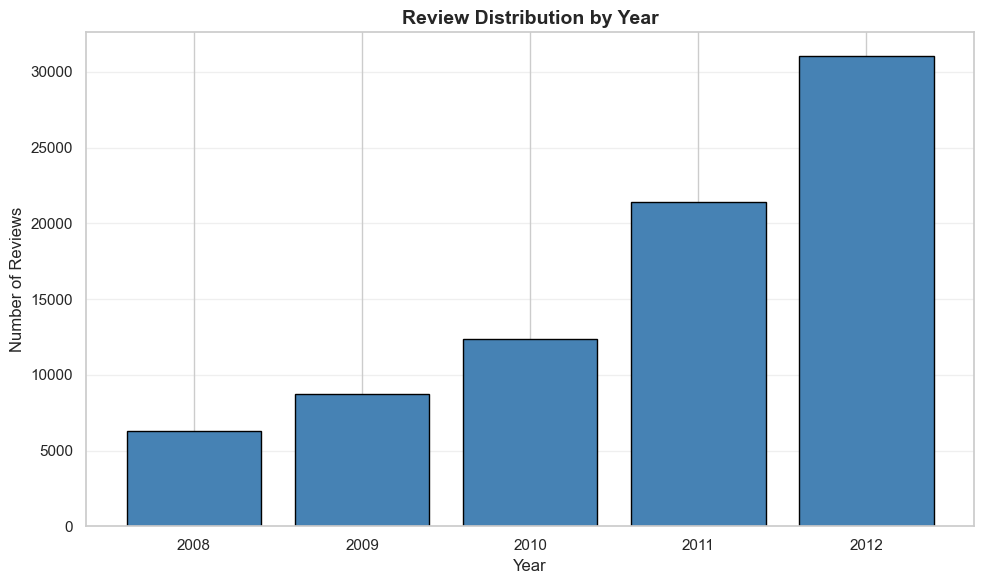

 year  count
 2008   6280
 2009   8717
 2010  12396
 2011  21397
 2012  31063


In [22]:
year_dist = pd.read_sql("""
    SELECT 
        CAST(SUBSTR(TRIM(date), -4) AS INTEGER) AS year,
        COUNT(*) as count
    FROM reviews
    WHERE date IS NOT NULL AND LENGTH(TRIM(date)) >= 4
    GROUP BY year
    ORDER BY year
""", engine)

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(year_dist['year'], year_dist['count'], color='steelblue', edgecolor='black')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Number of Reviews', fontsize=12)
ax.set_title('Review Distribution by Year', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(year_dist.to_string(index=False))

## Sample Database Creation

Creating 5,000-review sample for TA testing and quick iteration.
Run from project root: `python -m src.data_processing`


In [6]:
from src.data_processing import build_sample_db
try:
    path = build_sample_db(sample_size=5000)
    print(f"Created {path}")
    import sqlite3
    with sqlite3.connect(str(sample_path)) as conn:
        n = conn.execute("SELECT COUNT(*) FROM reviews").fetchone()[0]
    print(f"   Sample DB has {n:,} reviews")
except FileNotFoundError as e:
    print("Run: python -m src.data_processing --full-etl first.", e)

Created C:\Users\rayya\Desktop\IS5126-G4-hotel-analytics-master\data\reviews_sample.db
   Sample DB has 5,000 reviews
